# In this worksheet, we'll start evolving neural network controllers for our robots!

In [66]:
from IPython.display import display, clear_output
from jyro.simulator import *
import random
import numpy as np

### Just bringing back our `SimpleNeuralNet` class from earlier

In [67]:
class SimpleNeuralNet():
    #This is our squashing function
    #I changed this to the hyperbolic tangent function that
    #returns values in (-1, 1)
    def activation_function(self, x):
        return np.tanh(x)
    
    #this should look familiar, just a way to create a copy of 
    #the network without worying about pesky reference 
    def deepcopy(self):
        new_net = SimpleNeuralNet(self.num_inputs, self.num_outputs, self.layer_node_counts)
        new_net.layers = [np.copy(layer) for layer in self.layers]
        return new_net
    
    #this is where the neural network does its computation!
    def execute(self, input_vector):
        # First we need to make sure we're getting the right
        # number of inputs into our neural network.
        assert len(input_vector) == self.num_inputs ,\
        "wrong input vector size"

        # create a temporary variable to hold the values that should go
        # into the next layer of the network.
        # **at the start, this will just be our input**
        next_v = input_vector

        # iterate through layers, computing the activation
        # of the weighted inputs from the previous layer
        for layer in self.layers:
            # add a bias to each layer [1]
            next_v = np.append(next_v, 1)
            
            # pump the input vector through the matrix multiplication
            # and our activation function
            next_v = self.activation_function(np.dot(next_v, layer))
            
        return next_v
        
    def __init__(self, num_inputs, num_outputs, layer_node_counts=[]):
        self.num_inputs = num_inputs
        self.layer_node_counts = layer_node_counts
        self.num_outputs = num_outputs
        self.layers = []
        
        last_num_neurons = self.num_inputs
        for nc in layer_node_counts + [num_outputs]:
            # for now, we'll just use random weights in the range [-5,5]
            # +1 handles adding a bias node for each layer of nodes
            self.layers.append(np.random.uniform(-5, 5, size=(last_num_neurons+1, nc)))
            last_num_neurons = nc
    

## This code is mostly the same, but we're setting up the world a bit differently. Here we are setting up the simulation without all the interactive bits to speed it up.

In [68]:
class MyPioneer(Pioneer):
    def __init__(self, name, x, y, angle):
        Pioneer.__init__(self, name, x, y, angle)
        self.addDevice(Pioneer16Sonars())
        #parameter defines max range in meters
        self.addDevice(PioneerFrontLightSensors(3))
        self.addDevice(Camera())

        
robot = MyPioneer("Johnny", 1, 1, 0)
sim = Physics()
sim.addBox(0, 0, 8, 8, fill="backgroundgreen", wallcolor="gray") #bounding box
sim.addLight(7, 7, 1) #paramters are x, y, brightness

sim.addRobot(robot)

## If we wanted to get a visual of the simulator though, we still can by asking the simulation to draw itself! 

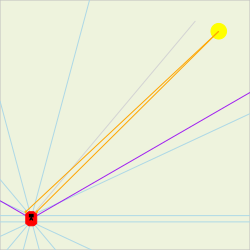

In [69]:
canvas = Canvas((250, 250))
sim.draw(canvas)

## Let's run a simple walking brain on our robot for 100 timesteps.

In [70]:
def walking_brain(robot):
    robot.move(1, 0)
    
robot.brain = walking_brain

for i in range(100):
    sim.step(run_brain=True)

### Notice nothing happened in our image above. That's because its a *still shot* of the simulator when we called it. We can call it again to get a picture of what the simulated world looks like now, though. 

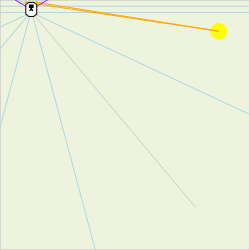

In [71]:
canvas = Canvas((250, 250))
sim.draw(canvas)

# We're going to define a weird helper function that returns a function. That sounds complicated, but it's pretty easy once you look at it. 

### We need this because the Jyro simulator expects the brain of a robot to be a function. But, we want to use neural networks to control that function, so we need a way of plugging our neural networks into the robot brain function easily. 

In [72]:
def network_to_brain(simple_net):
    
    #Define the brain function for jyro
    def neural_brain(a_robot):
        sonar_sensors = a_robot["sonar"].getData()
        light_sensors = a_robot["light"].getData()
        
        #combine the sonar and light inputs
        combined_input = sonar_sensors + light_sensors

        network = simple_net

        #run the neural network with the combined input values
        output = network.execute(combined_input)
        
        #use the output of the network to move the robot
        a_robot.move(output[0], output[1])

    return neural_brain

### Let's reset our robot and try running a random neural brain now!

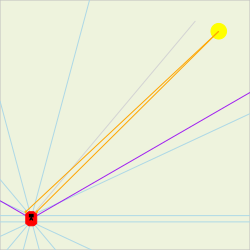

In [73]:
robot.setPose(1,1,0)
robot.reset()

#make a neural net with 18 inputs, and 2 outputs, and no hidden neurons for now.
neural_net = SimpleNeuralNet(18,2, []) 

#turn our neural network into a robot brain, and assign it
robot.brain = network_to_brain(neural_net)


canvas = Canvas((250, 250))
sim.draw(canvas)

## Even though we're not in the visual simulator, we can watch the simulation by drawing each time step as we run the simulation.

#### This is not something you should do while you're trying to evaluate a bunch of brains though!

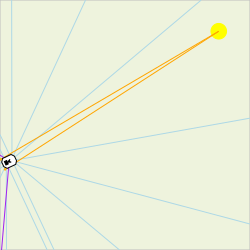

In [74]:
for i in range(50):
    #run the simulation for one step
    sim.step(run_brain=True)
    
    #draw the output, overwriting the last
    sim.draw(canvas)
    clear_output(wait=True)
    display(canvas)
    
    #pause for enough time to enjoy it
    time.sleep(.085)

## I'm bringing in some helper functions we wrote in previous notebooks. 

## `tournament_selection` expects a list of individuals (in our case, neural networks) and a list of their fitness values. 
I'm passing in a fitness list instead of evaluating individuals every time we encounter them because evaluation is much slower in this environment. 

## `mutate_network` expects a network, and optionally the probability of mutating an edge weight (`mutation_rate`) and the effect size of the mutations (`mutation_effect_size`)
This function tries to be speedy with mutations, by calculating how many mutations should occur, and then picking the ones to mutate randomly from the neurons. 

In [75]:
def tournament_selection(population, fitnesses, tournament_size=3):
    sample_pop_idxs = np.random.choice(range(len(population)), size=tournament_size)
    tourny_winner_idx = np.argmax(np.array(fitnesses)[sample_pop_idxs])
    winner_pop_idx = sample_pop_idxs[tourny_winner_idx]

    return population[winner_pop_idx]
    
def mutate_network(simple_net, mutation_rate=1E-3, mutation_effect_size=2):
    for layer_to_mut in simple_net.layers:
        dims = layer_to_mut.shape
        num_mutations = np.random.binomial(dims[0]*dims[1], mutation_rate)
        for i in range(num_mutations):
            rand_i = np.random.randint(0, dims[0])
            rand_j = np.random.randint(0, dims[1])
            layer_to_mut[rand_i, rand_j] += np.random.normal(scale=mutation_effect_size)


# Now we have to figure out a way of evaluating our brains.
#### We'll stick the network into the brain of the robot, and run it in the simulation (without visualizing it so it goes fast). 

# But, what should we reward?
#### In this simple fitness function, I'm just counting up how far the robot moved during it's trial and calling that it's fitness. 

In [76]:
def measure_neuralnet_fitness(simple_net, iterations=20):
    robot.brain = network_to_brain(simple_net)
    distance_moved = 0
    
    #reset the robot's position
    robot.setPose(1, 1, 0)
    robot.reset()
    
    #iterate through the simulation
    for i in range(iterations):        
        #but if the robot's stuck, end early!
        if robot.stall:
            break
            
        #move the robot
        cur_pos = robot.getPose()
        sim.step(run_brain=True)
        next_pos = robot.getPose()
        
        #and keep track of how far it moved
        distance_moved += np.linalg.norm(np.array(cur_pos[0:2]) - np.array(next_pos[0:2]))
        
    return distance_moved

# So, now we can measure fitness, let's evolve some robot brains! 
## We'll start off small, because this is a slow simulation. We'll use a population of 20 robots, and let them evolve them for 10 genrations.

## We'll also only use 50 timesteps of the simulation for each evaluation. 

In [80]:
pop_size = 20
generations = 10

#build our random population of neural networks
population = [SimpleNeuralNet(18,2,[5]) for _ in range(pop_size)]
evo_fitnesses = []

for i in range(generations):
    #evaluate the fitnesses using 50 timesteps
    fitnesses = [measure_neuralnet_fitness(n, iterations=50) for n in population]
    
    #keep track of the mean pop fitnesses
    evo_fitnesses.append(np.mean(fitnesses))
    
    #print the generation and the mean fitness we just stuck on the
    #evo_fitnesses list
    clear_output(wait=True)
    display(i, evo_fitnesses[-1])
    
    #do tournament selection
    next_pop = [tournament_selection(population, fitnesses).deepcopy() for _ in range(pop_size)]
    
    #and mutate the new networks
    for net in next_pop:
        mutate_network(net, mutation_rate=0.01)
    
    population = next_pop

[0.0, 0.0]
[0.0, 0.0]
[0.0, 0.0]
[0.0, 0.0]
[0.0, 0.0]
[0.0, 0.0]
[0.0, 0.0]
[0.0, 0.0]


KeyboardInterrupt: 

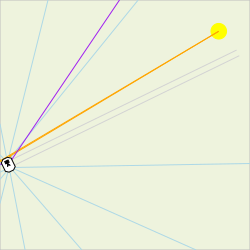

In [58]:
#let's visualize the first individual in the population
#Note there is no reason to expect this is the best individual!
robot.brain = network_to_brain(population[10])
robot.setPose(1,1,0)

for i in range(50):
    sim.step(run_brain=True)
    sim.draw(canvas)
    clear_output(wait=True)
    display(canvas)
    time.sleep(.085)

# 1. Change the visualization code above to visualize the *best* solution in the population. Hint: `np.argmax` is a function worth keeping in your back pocket at all times. 

In [53]:
robot.brain = network_to_brain(population[np.argmax([measure_neuralnet_fitness(brain, iterations=100) for brain in population])])
robot.setPose(1,1,0)
for i in range(100):
    sim.step(run_brain=True)
    sim.draw(canvas)
    clear_output(wait=True)
    display(canvas)
    time.sleep(.085)

KeyboardInterrupt: 

# 2. It seems like fitness is saturating. Why do you think that is? What could you do to "fix" this?

In [ ]:
print([measure_neuralnet_fitness(brain, iterations=100) for brain in population])

# 3.  After fixing this saturation problem, see if you can evolve robots that navigate to the light source! 
## To do this, you will need to change the way fitness is evaluated

In [79]:
# CHANGE THIS FUNCTION
def measure_neuralnet_fitness(simple_net, iterations=20):
    robot.brain = network_to_brain(simple_net)
    distance_moved = 0
    
    #reset the robot's position
    robot.setPose(1, 1, 0)
    robot.reset()
    current_light = np.array(robot['light'].getData())
    #iterate through the simulation
    for i in range(iterations):        
        #but if the robot's stuck, end early!
        if robot.stall:
            break
            
        #move the robot
        cur_pos = robot.getPose()
        sim.step(run_brain=True)
        next_pos = robot.getPose()
        
        #and keep track of how far it moved
        distance_moved += np.linalg.norm(np.array(cur_pos[0:2]) - np.array(next_pos[0:2]))
    distance_closed = sum(np.array(robot["light"].getData()) - current_light)
    print(robot["light"].getData())
#     distance_closed_ratio = float(distance_closed/distance_moved)
    return distance_closed

In [65]:
robot["light"].getData()

[0.0, 0.0]